In [214]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner
from astropy.modeling import models
import astropy.units as u
from scipy.stats import norm, uniform

%matplotlib inline

In [192]:
def log_likelihood(theta, x, y, yerr):
    T_guess, a_guess, log_f = theta
    y, yerr =  y.value, yerr.value
    model = models.BlackBody(temperature = T_guess*u.K, scale = a_guess * u.MJy/u.sr)

    sigma2 = yerr ** 2 + model(x).value ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(x).value) ** 2 / sigma2 + np.log(sigma2))

In [224]:
def log_prior(theta):
    T_guess, a_guess, log_f = theta
    if T_guess > 0:
        T_prior = norm(loc = 30, scale = 20).pdf(T_guess)
    else:
        T_prior = -np.inf
    a_prior = uniform().pdf(a_guess)
    log_f_prior = uniform(loc = -10, scale = 20).pdf(log_f)
    return T_prior*a_prior*log_f_prior

In [123]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

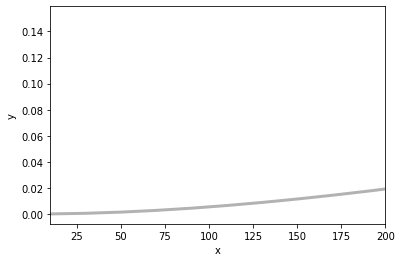

In [196]:
np.random.seed(123)

# Choose the "true" parameters.
#alpha_true = 1
#amp_true = 2
#x_0_true = 50

T_true = 20
a_true = 1e-6

f_true = 0.594

#power_law = models.PowerLaw1D(amplitude = amp_true, x_0 = x_0_true, alpha = alpha_true)

bb = models.BlackBody(temperature = T_true*u.K, scale = a_true * u.MJy/u.sr)
"""
# Generate some synthetic data from the model.
N = 50
#x = np.linspace(10,100, N)
x = np.linspace(10, 1000, N) * u.GHz
yerr = (0.01 + 0.05 * np.random.rand(N))*u.MJy/u.sr
#y = power_law(x)
y = bb(x)
y += np.abs(f_true * y) * 0.1*np.random.randn(N)
y += yerr * np.random.randn(N)
"""


#plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
x0 = np.linspace(10, 2000, 100)*u.GHz
plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3)
plt.xlim(10, 200)
plt.xlabel("x")
plt.ylabel("y");


In [252]:
x = np.array([1362.69, 250, 350, 500])*u.um
x = x.to(u.GHz, equivalencies=u.spectral())
y_18 = [4*0.00701, 0.25661746, 0.18368292, 0.08300887]*u.MJy/u.sr
y_24 = [0.000353, 0.23656521, 0.16732553, 0.07550188]*u.MJy/u.sr

y = y_24
yerr = np.array([0.000145, 0.0384, 0.0144, 0.00608])*u.MJy/u.sr

i = 1
x, y, yerr = x[i:], y[i:], yerr[i:]


Maximum likelihood estimates:
T = 38.279
amp = 2.847e-07
f = 5.147e-02


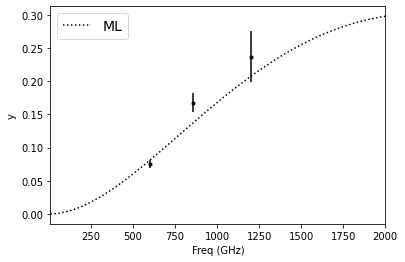

In [253]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([20, 1e-6, np.log(f_true)])

soln = minimize(nll, initial, args=(x, y, yerr))
T_ml, a_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("T = {0:.3f}".format(T_ml))
print("amp = {0:.3e}".format(a_ml))
#print("x_0 = {0:.3f}".format(x_0_ml))
print("f = {0:.3e}".format(np.exp(log_f_ml)))

plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')
plt.plot(x0, models.BlackBody(temperature = T_ml*u.K, scale = a_ml * u.MJy/u.sr)(x0), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(10, 2000)

plt.xlabel("Freq (GHz)")
plt.ylabel("y");

In [207]:
print(models.BlackBody(temperature = T_ml*u.K, scale = a_ml * u.MJy/u.sr)(220*u.GHz))

0.018029747349858002 MJy / sr


In [225]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


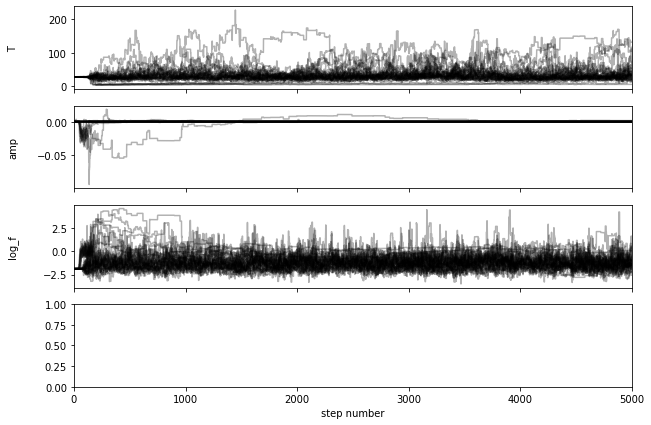

In [226]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['T', 'amp', 'log_f']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [227]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [256.61700892  69.59574244 158.42349684]

In [228]:
flat_samples = sampler.get_chain(discard=int(max(tau)), thin=15, flat=True)
print(flat_samples.shape)

(10560, 3)


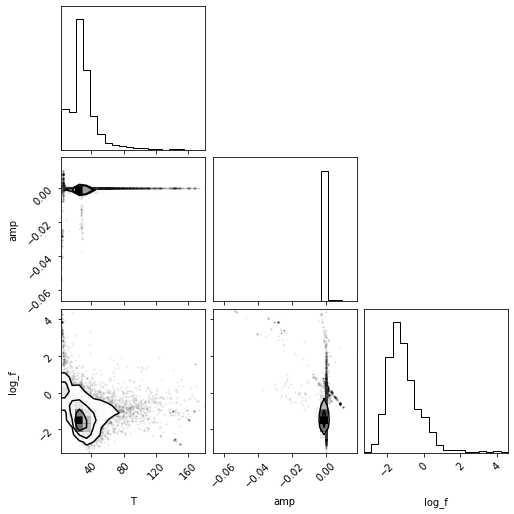

In [232]:
fig = corner.corner(
    flat_samples, labels=labels
);

In [234]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3e}_{{-{1:.3e}}}^{{{2:.3e}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>